In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

from forecasting_dataset import ForecastingDataset
from config import Config
from metrics import mae

from data_reading import read_dataset
from model_config import ModelConfig
from models.create_model import create_model, create_model_with_wrapper
from models.train_model import train_model
from models.train_model import predict

from utility import components_to_features, set_random_seed

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "Times New Roman"

c = Config()

In [ ]:
def train_predict_model(decomp, algorithm, dataset, decomp_param_changes, wrap=True):
    decomp_params = c.default_decomp_params.copy()
    for d, val in decomp_param_changes.items():
        decomp_params[d] = val
    df = read_dataset(dataset)
    if df.shape[1] < 3* (c.horizon + c.backhorizon):
        horizon = c.short_horizon
        backhorizon = c.short_backhorizon
    else:
        horizon = c.horizon
        backhorizon = c.backhorizon
    data = ForecastingDataset(df, 
                            horizon=horizon, 
                            backhorizon=backhorizon, 
                            train_size=c.train_size, 
                            val_size=c.val_size, 
                            stride_length=c.stride_lengths[dataset],
                            decomposition=None,
                            fixed_origin=False)
    # data.scale()
    data.decompose(decomp, decomp_params)
    mc = ModelConfig(data, decomposition_parameters=decomp_params)
    mc.interpretable_outputs = True
    if wrap:
        model = create_model_with_wrapper(algorithm, mc, with_decomp=False)
    else:
        model = create_model(algorithm, mc)
    model_trained = train_model(model, 
                                mc, 
                                components_to_features(data, "X_train"),
                                data.get_attr_flat("y_train", order="NCL"),
                                components_to_features(data, "X_val"),
                                data.get_attr_flat("y_val", order="NCL"),
                                experiment_path="experiment_7")
    return model_trained, data, predict(model_trained, mc, components_to_features(data, "X_test"), is_ragged_length=data.is_ragged_length)

In [ ]:
dataset = c.interpretability_datasets[0]
algorithm = c.interpretability_algorithms[0]
decomp = c.interpretability_decomps[0]
channel_index = c.interpretability_channels[0]
instance_index = c.interpretability_samples[0]
decomp_param_changes = {
    "decomposition_period": 7
}
model, data, y_pred = train_predict_model(decomp, algorithm, dataset, decomp_param_changes)
horizon = y_pred.shape[-1]

In [19]:
df = pd.read_csv("data/UTS/transactions.csv")
df = pd.pivot(df, index=["store_nbr"], columns=["date"], values=["transactions"])
all_rows = []
for _, row in df.iterrows():
    row.dropna(inplace=True)
    all_rows.append(np.array(row))

transactions = pd.DataFrame(all_rows)

offset = int(0.8*df.shape[1]) + 231
timestamps = df.iloc[0,offset:offset+c.backhorizon+c.horizon].index.get_level_values(1)
timestamps = pd.to_datetime(timestamps).strftime("%b-%d")

/var/folders/y9/3vmyk1sj3gdg57c8wdhmps4m0000gp/T/ipykernel_50199/3692588440.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize": "large"})


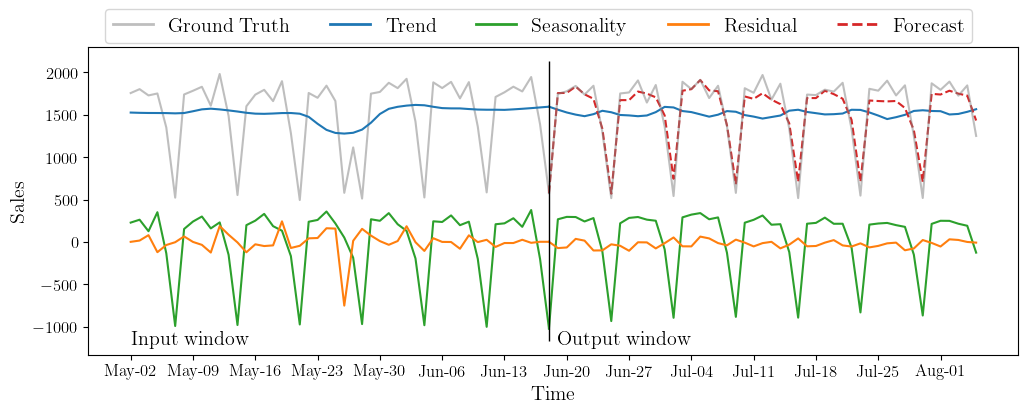

In [ ]:
SUM_COLOR = ("tab:grey",0.5)
FORECAST_COLOR = "tab:red"
TREND_COLOR = "tab:blue"
SEASONAL_COLOR = "tab:green"
RESIDUAL_COLOR = "tab:orange"

n_components = model.out_interpretable.shape[0]

fig, ax = plt.subplots(figsize=(12,4))
# Plot input
x = data.get_attr_flat("X_test", order="NCL")[instance_index, channel_index]
trend = data.get_attr_flat("X_test_trend", order="NCL")[instance_index, channel_index]
seasonality = data.get_attr_flat("X_test_seasonal", order="NCL")[instance_index, channel_index]
residual = data.get_attr_flat("X_test_residual", order="NCL")[instance_index, channel_index]
comps = {
    "trend": trend,
    "seasonal": seasonality,
    "residual": residual,
}
colors = {
    "trend": TREND_COLOR,
    "seasonal": SEASONAL_COLOR,
    "residual": RESIDUAL_COLOR,
}

ax.plot(timestamps[:len(x)],x,color=SUM_COLOR)
ax.plot(timestamps[:len(trend)],trend,color=TREND_COLOR)
ax.plot(timestamps[:len(seasonality)],seasonality,color=SEASONAL_COLOR)
ax.plot(timestamps[:len(residual)],residual,color=RESIDUAL_COLOR)

# # Plot forecast
for component in range(n_components):
    vals = model.out_interpretable[component,instance_index,channel_index].numpy()
    concat = np.concatenate([comps[data.decomposition_variables[component]][-1:], vals])
    ax.plot(timestamps[len(x)-1:len(x)-1+len(concat)], concat, label=data.decomposition_variables[component], color=colors[data.decomposition_variables[component]])


yhat = np.concatenate([x[-1:], y_pred[instance_index,channel_index]])
ax.plot(timestamps[len(x)-1:len(x)-1+len(yhat)], yhat, label="y", color=FORECAST_COLOR, linestyle="--")
ytrue = np.concatenate([x[-1:], data.get_attr_flat("y_test", order="NCL")[instance_index, channel_index]])
ax.plot(timestamps[len(x)-1:len(x)-1+len(ytrue)], ytrue, label="y", color=SUM_COLOR)
legend_artists = {
    "Ground Truth": Line2D([0], [0], color=SUM_COLOR, lw=2),
    "Trend": Line2D([0], [0], color=TREND_COLOR, lw=2),
    "Seasonality": Line2D([0], [0], color=SEASONAL_COLOR, lw=2),
    "Residual": Line2D([0], [0], color=RESIDUAL_COLOR, lw=2),
    "Forecast": Line2D([0], [0], color=FORECAST_COLOR, lw=2, linestyle="--"),
}

fig.legend(handles=list(legend_artists.values()), 
           labels=list(legend_artists.keys()), 
           ncol=len(legend_artists), 
           loc="upper center", 
           fontsize="x-large", 
           bbox_to_anchor=(0.5, 1))

ax.vlines(x=len(x)-1,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],color="black",lw=1)

ax.text(s="Input window", x=0, y=ax.get_ylim()[0] *0.9, fontdict={"fontsize": "x-large"})
ax.text(s="Output window", x=horizon, y=ax.get_ylim()[0] *0.9, fontdict={"fontsize": "x-large"})

ax.set_xlabel("Time", fontdict={"fontsize": "x-large"})

ax.xaxis.set_major_locator(plt.MultipleLocator(7))

# Customize the font size of x-axis ticks
plt.setp(ax.xaxis.get_majorticklabels(), fontsize='large')
ax.set_xticks(ax.get_xticks()[1:-2])

ax.set_ylabel("Sales", fontdict={"fontsize": "x-large"})
ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize": "large"})

fig.savefig("plots/interpretability_stl_transactions.pdf", bbox_inches="tight")

In [ ]:
dataset = c.interpretability_datasets[1]
algorithm = c.interpretability_algorithms[1]
decomp = c.interpretability_decomps[1]
channel_index = c.interpretability_channels[1]
instance_index = c.interpretability_samples[1]
model, data, y_pred = train_predict_model(decomp, algorithm, dataset, {})
horizon = y_pred.shape[-1]

/var/folders/y9/3vmyk1sj3gdg57c8wdhmps4m0000gp/T/ipykernel_94316/3488204990.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize": "large"})


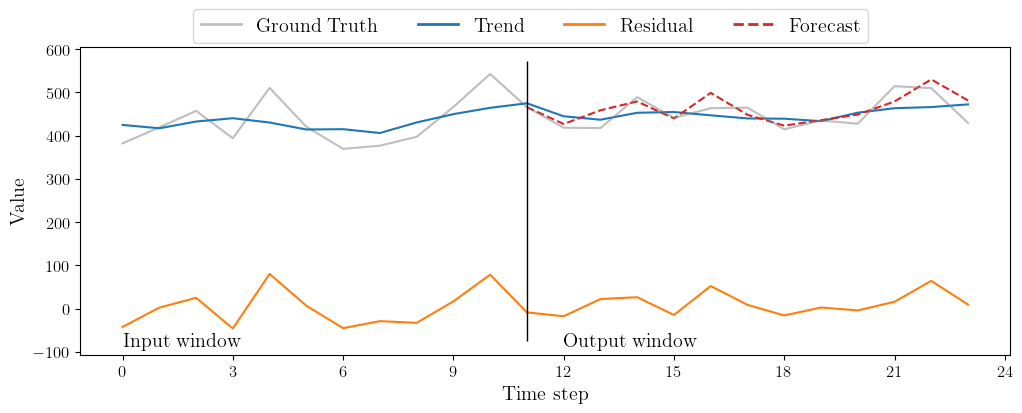

In [ ]:
SUM_COLOR = ("tab:grey",0.5)
FORECAST_COLOR = "tab:red"
TREND_COLOR = "tab:blue"
RESIDUAL_COLOR = "tab:orange"
channel_index = 0
instance_index = 800
n_components = model.out_interpretable.shape[0]

fig, ax = plt.subplots(figsize=(12,4))
# Plot input
x = data.get_attr_flat("X_test", order="NCL")[instance_index, channel_index]
trend = data.get_attr_flat("X_test_avg", order="NCL")[instance_index, channel_index]
residual = data.get_attr_flat("X_test_residual", order="NCL")[instance_index, channel_index]
comps = {
    "avg": trend,
    "residual": residual,
}
colors = {
    "avg": TREND_COLOR,
    "residual": RESIDUAL_COLOR,
}
ax.plot(np.arange(len(x)),x,color=SUM_COLOR)
ax.plot(np.arange(len(trend)),trend,color=TREND_COLOR)
ax.plot(np.arange(len(residual)),residual,color=RESIDUAL_COLOR)

# # Plot forecast
for component in range(n_components):
    concat = np.concatenate([comps[data.decomposition_variables[component]][-1:], model.out_interpretable[component,instance_index,channel_index]])
    ax.plot(np.arange(len(concat))+len(x)-1, concat, label=data.decomposition_variables[component], color=colors[data.decomposition_variables[component]])
yhat = np.concatenate([x[-1:], y_pred[instance_index,channel_index]])
ax.plot(np.arange(len(yhat))+len(x)-1, yhat, label="y", color=FORECAST_COLOR, linestyle="--")
ytrue = np.concatenate([x[-1:], data.get_attr_flat("y_test", order="NCL")[instance_index, channel_index]])
ax.plot(np.arange(len(ytrue))+len(x)-1, ytrue, label="y", color=SUM_COLOR)

legend_artists = {
    "Ground Truth": Line2D([0], [0], color=SUM_COLOR, lw=2),
    "Trend": Line2D([0], [0], color=TREND_COLOR, lw=2),
    "Residual": Line2D([0], [0], color=RESIDUAL_COLOR, lw=2),
    "Forecast": Line2D([0], [0], color=FORECAST_COLOR, lw=2, linestyle="--"),
}

fig.legend(handles=list(legend_artists.values()), 
           labels=list(legend_artists.keys()), 
           ncol=len(legend_artists), 
           loc="upper center", 
           fontsize="x-large", 
           bbox_to_anchor=(0.5, 1))

ax.vlines(x=len(x)-1,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],color="black",lw=1)

ax.text(s="Input window", x=0, y=ax.get_ylim()[0] *0.8, fontdict={"fontsize": "x-large"})
ax.text(s="Output window", x=horizon, y=ax.get_ylim()[0] *0.8, fontdict={"fontsize": "x-large"})

ax.set_xlabel("Time step", fontdict={"fontsize": "x-large"})
ax.set_xticks(np.arange(9)*3, np.arange(9)*3, fontsize= "large")
ax.set_ylabel("Value", fontdict={"fontsize": "x-large"})
ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize": "large"})

fig.savefig("plots/interpretability_moving_avg_cif.pdf", bbox_inches="tight");

In [13]:
dataset = c.interpretability_datasets[2]
algorithm = c.interpretability_algorithms[2]
decomp = c.interpretability_decomps[2]
channel_index = c.interpretability_channels[2]
instance_index = c.interpretability_samples[2]
model, data, y_pred = train_predict_model(decomp, algorithm, dataset, {})
horizon = y_pred.shape[-1]

/var/folders/y9/3vmyk1sj3gdg57c8wdhmps4m0000gp/T/ipykernel_54384/123842323.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize": "large"})


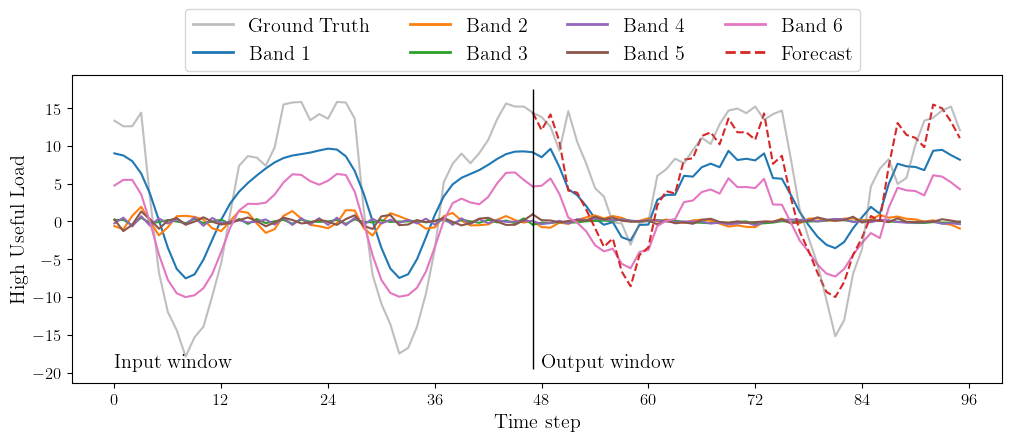

In [14]:
SUM_COLOR = ("tab:grey",0.5)
FORECAST_COLOR = "tab:red"

COMPONENT_COLORS = ["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:brown", "tab:pink"]
channel_index = 0
instance_index = 200
n_components = model.out_interpretable.shape[0]

fig, ax = plt.subplots(figsize=(12,4))
# Plot input
x = data.get_attr_flat("X_test", order="NCL")[instance_index, channel_index]
components = [data.get_attr_flat(f"X_test_{i}", order="NCL")[instance_index, channel_index] for i in data.decomposition_variables]

ax.plot(np.arange(len(x)),x,color=SUM_COLOR)
for comp, color in zip(components, COMPONENT_COLORS):
    ax.plot(np.arange(len(comp)),comp,color=color)

# # Plot forecast
for comp, color, pred in zip(components, COMPONENT_COLORS, model.out_interpretable):
    concat = np.concatenate([comp[-1:], pred[instance_index,channel_index]])
    ax.plot(np.arange(len(concat))+len(x)-1, concat, color=color)
yhat = np.concatenate([x[-1:], y_pred[instance_index,channel_index]])
ax.plot(np.arange(len(yhat))+len(x)-1, yhat, label="y", color=FORECAST_COLOR, linestyle="--")
ytrue = np.concatenate([x[-1:], data.get_attr_flat("y_test", order="NCL")[instance_index, channel_index]])
ax.plot(np.arange(len(ytrue))+len(x)-1, ytrue, label="y", color=SUM_COLOR)

legend_artists = {
    "Ground Truth": Line2D([0], [0], color=SUM_COLOR, lw=2),
}
for color, name in zip(COMPONENT_COLORS, data.decomposition_variables):
    legend_artists[f"Band {int(name)+1}"] = Line2D([0], [0], color=color, lw=2)
legend_artists["Forecast"] = Line2D([0], [0], color=FORECAST_COLOR, lw=2, linestyle="--")

fig.legend(handles=list(legend_artists.values()), 
           labels=list(legend_artists.keys()), 
           ncol=4,
           loc="upper center", 
           fontsize="x-large", 
           bbox_to_anchor=(0.5, 1.07))

ax.vlines(x=len(x)-1,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],color="black",lw=1)

ax.text(s="Input window", x=0, y=ax.get_ylim()[0] *0.9, fontdict={"fontsize": "x-large"})
ax.text(s="Output window", x=horizon, y=ax.get_ylim()[0] *0.9, fontdict={"fontsize": "x-large"})

ax.set_xlabel("Time step", fontdict={"fontsize": "x-large"})
ax.set_xticks(np.arange(9)*(horizon//4), np.arange(9)*(horizon//4), fontsize= "large")
ax.set_ylabel("High Useful Load", fontdict={"fontsize": "x-large"})
ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize": "large"})

fig.savefig("plots/interpretability_fourier_bandlimited_etth1.pdf", bbox_inches="tight");

# Wavelet, stacked plot

In [ ]:
all_levels = [1,2,3,4,5]
models = []
datas = []
y_preds = []
errors = []

set_random_seed(0)

for level in all_levels:
    dataset = c.interpretability_datasets[2]
    algorithm = c.interpretability_algorithms[2]
    decomp = "wavelet"
    channel_index = c.interpretability_channels[2]
    instance_index = c.interpretability_samples[2]
    decomp_param_changes = {
        "decomposition_levels": level
    }
    model, data, y_pred = train_predict_model(decomp, algorithm, dataset, decomp_param_changes)
    models.append(model)
    datas.append(data)
    y_preds.append(y_pred)
    error = mae(data.get_attr_flat("X_test", order="NCL")[instance_index,channel_index],y_pred[instance_index,channel_index])
    errors.append(error)
    print(error)

3.5866504443498948
3.9985817844669023


/Users/tikr7960/Library/Python/3.9/lib/python/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(


5.0513439029455185


/Users/tikr7960/Library/Python/3.9/lib/python/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


3.8773775727798543


/Users/tikr7960/Library/Python/3.9/lib/python/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


3.537510701765617


/var/folders/y9/3vmyk1sj3gdg57c8wdhmps4m0000gp/T/ipykernel_54384/1187414868.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize": "large"})
/var/folders/y9/3vmyk1sj3gdg57c8wdhmps4m0000gp/T/ipykernel_54384/1187414868.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize": "large"})
/var/folders/y9/3vmyk1sj3gdg57c8wdhmps4m0000gp/T/ipykernel_54384/1187414868.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize": "large"})


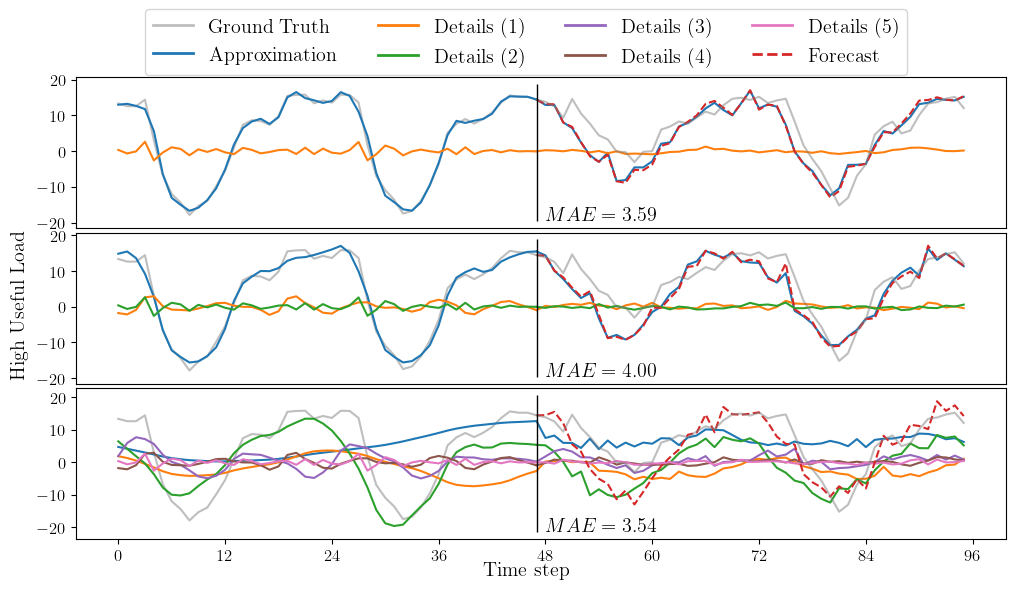

In [ ]:
fig, axs = plt.subplots(figsize=(12,6), nrows=3, gridspec_kw={"hspace": 0.03})
# fig, axs = plt.subplots(figsize=(12,12), nrows=len(all_bands), gridspec_kw={"hspace": 0.03})

j = 0
for i, model, data, y_pred, error in zip(np.arange(len(all_levels)), models, datas, y_preds, errors):
    if i not in [0,1,4]: # Skip some setups to make the plot smaller
        continue
    ax = axs[j]
    j += 1
    horizon = y_pred.shape[-1]
    SUM_COLOR = ("tab:grey",0.5)
    FORECAST_COLOR = "tab:red"

    COMPONENT_COLORS = ["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:brown", "tab:pink"]
    n_components = model.out_interpretable.shape[0]

    # Plot input
    x = data.get_attr_flat("X_test", order="NCL")[instance_index, channel_index]
    components = [data.get_attr_flat(f"X_test_{i}", order="NCL")[instance_index, channel_index] for i in data.decomposition_variables]

    ax.plot(np.arange(len(x)),x,color=SUM_COLOR)
    for comp, color in zip(components, COMPONENT_COLORS):
        ax.plot(np.arange(len(comp)),comp,color=color)

    # # Plot forecast
    for comp, color, pred in zip(components, COMPONENT_COLORS, model.out_interpretable):
        concat = np.concatenate([comp[-1:], pred[instance_index,channel_index]])
        ax.plot(np.arange(len(concat))+len(x)-1, concat, color=color)
    yhat = np.concatenate([x[-1:], y_pred[instance_index,channel_index]])
    ax.plot(np.arange(len(yhat))+len(x)-1, yhat, label="y", color=FORECAST_COLOR, linestyle="--")
    ytrue = np.concatenate([x[-1:], data.get_attr_flat("y_test", order="NCL")[instance_index, channel_index]])
    ax.plot(np.arange(len(ytrue))+len(x)-1, ytrue, label="y", color=SUM_COLOR)

    ax.vlines(x=len(x)-1,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],color="black",lw=1)

    # ax.text(s="Input window", x=0, y=ax.get_ylim()[0] *0.9, fontdict={"fontsize": "x-large"})
    # ax.text(s="Output window", x=horizon, y=ax.get_ylim()[0] *0.9, fontdict={"fontsize": "x-large"})

    # ax.set_xlabel("Time step", fontdict={"fontsize": "x-large"})
    ax.set_xticks([],[])
    ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize": "large"})
    ax.text(s="$MAE={:.2f}$".format(error), x=horizon, y=ax.get_ylim()[0]*0.9, fontdict={"fontsize": "x-large"})

legend_artists = {
    "Ground Truth": Line2D([0], [0], color=SUM_COLOR, lw=2),
    "Approximation": Line2D([0], [0], color=COMPONENT_COLORS[0], lw=2)
}
for color, name in zip(COMPONENT_COLORS[1:], data.decomposition_variables[1:]):
    legend_artists[f"Details ({int(name)+1})"] = Line2D([0], [0], color=color, lw=2)
legend_artists["Forecast"] = Line2D([0], [0], color=FORECAST_COLOR, lw=2, linestyle="--")
fig.legend(handles=list(legend_artists.values()), 
    labels=list(legend_artists.keys()), 
    ncol=4,
    loc="upper center", 
    fontsize="x-large", 
    bbox_to_anchor=(0.5, 1.01))
axs[-1].set_xticks(np.arange(9)*(horizon//4), np.arange(9)*(horizon//4), fontsize= "large")
fig.text(0.07, 0.5, "High Useful Load", va="center", rotation="vertical", fontsize="x-large")
fig.text(0.5, 0.05, "Time step", ha="center", fontsize="x-large")

fig.savefig("plots/interpretability_wavelet_generic_etth1.pdf", bbox_inches="tight");

# Bandlimited Fourier, stacked plot

In [ ]:
all_bands = [2,3,4,5,6]
models = []
datas = []
y_preds = []
errors = []

set_random_seed(2)

for n_bands in all_bands:
    dataset = c.interpretability_datasets[2]
    algorithm = c.interpretability_algorithms[2]
    decomp = c.interpretability_decomps[2]
    channel_index = c.interpretability_channels[2]
    instance_index = c.interpretability_samples[2]
    decomp_param_changes = {
        "decomposition_n_bands": n_bands
    }
    model, data, y_pred = train_predict_model(decomp, algorithm, dataset, decomp_param_changes)
    models.append(model)
    datas.append(data)
    y_preds.append(y_pred)
    error = mae(data.get_attr_flat("X_test", order="NCL")[instance_index,channel_index],y_pred[instance_index,channel_index])
    errors.append(error)
    print(error)

3.620769607524077
3.6536302641034126
4.558142979939778
3.1798910771807036
2.8792946860194206


/var/folders/y9/3vmyk1sj3gdg57c8wdhmps4m0000gp/T/ipykernel_37698/3811838032.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize": "large"})
/var/folders/y9/3vmyk1sj3gdg57c8wdhmps4m0000gp/T/ipykernel_37698/3811838032.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize": "large"})
/var/folders/y9/3vmyk1sj3gdg57c8wdhmps4m0000gp/T/ipykernel_37698/3811838032.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize": "large"})


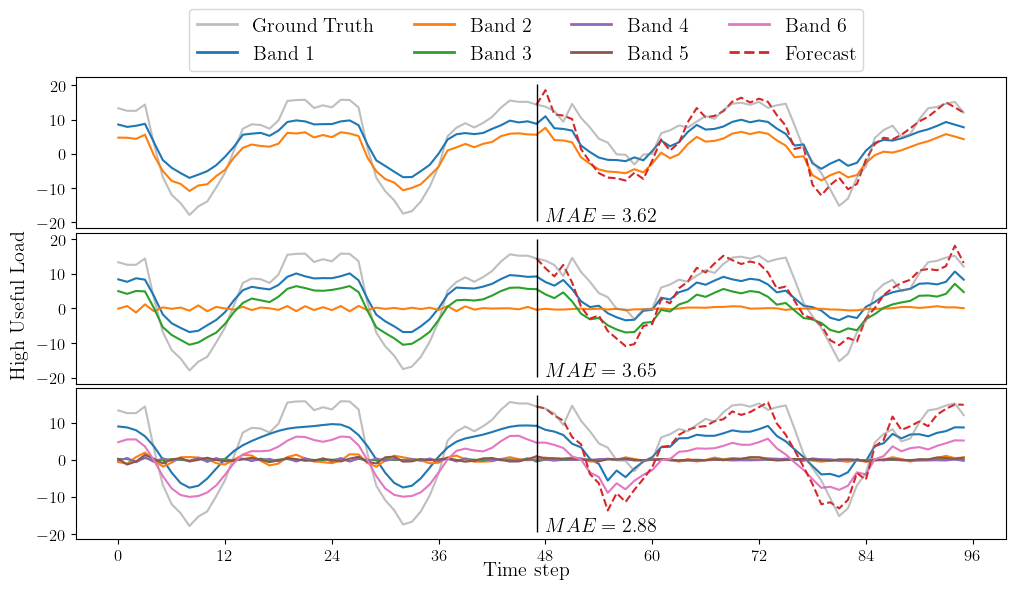

In [ ]:
fig, axs = plt.subplots(figsize=(12,6), nrows=3, gridspec_kw={"hspace": 0.03})
# fig, axs = plt.subplots(figsize=(12,12), nrows=len(all_bands), gridspec_kw={"hspace": 0.03})

j = 0
for i, model, data, y_pred, error in zip(np.arange(len(all_bands)), models, datas, y_preds, errors):
    if i not in [0,1,len(all_bands)-1]: # Skip some setups to make the plot smaller
        continue
    ax = axs[j]
    j += 1
    horizon = y_pred.shape[-1]
    SUM_COLOR = ("tab:grey",0.5)
    FORECAST_COLOR = "tab:red"

    COMPONENT_COLORS = ["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:brown", "tab:pink"]
    channel_index = 0
    instance_index = 200
    n_components = model.out_interpretable.shape[0]

    # Plot input
    x = data.get_attr_flat("X_test", order="NCL")[instance_index, channel_index]
    components = [data.get_attr_flat(f"X_test_{i}", order="NCL")[instance_index, channel_index] for i in data.decomposition_variables]

    ax.plot(np.arange(len(x)),x,color=SUM_COLOR)
    for comp, color in zip(components, COMPONENT_COLORS):
        ax.plot(np.arange(len(comp)),comp,color=color)

    # # Plot forecast
    for comp, color, pred in zip(components, COMPONENT_COLORS, model.out_interpretable):
        concat = np.concatenate([comp[-1:], pred[instance_index,channel_index]])
        ax.plot(np.arange(len(concat))+len(x)-1, concat, color=color)
    yhat = np.concatenate([x[-1:], y_pred[instance_index,channel_index]])
    ax.plot(np.arange(len(yhat))+len(x)-1, yhat, label="y", color=FORECAST_COLOR, linestyle="--")
    ytrue = np.concatenate([x[-1:], data.get_attr_flat("y_test", order="NCL")[instance_index, channel_index]])
    ax.plot(np.arange(len(ytrue))+len(x)-1, ytrue, label="y", color=SUM_COLOR)

    ax.vlines(x=len(x)-1,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],color="black",lw=1)

    # ax.text(s="Input window", x=0, y=ax.get_ylim()[0] *0.9, fontdict={"fontsize": "x-large"})
    # ax.text(s="Output window", x=horizon, y=ax.get_ylim()[0] *0.9, fontdict={"fontsize": "x-large"})

    # ax.set_xlabel("Time step", fontdict={"fontsize": "x-large"})
    ax.set_xticks([],[])
    ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize": "large"})
    ax.text(s="$MAE={:.2f}$".format(error), x=horizon, y=ax.get_ylim()[0]*0.9, fontdict={"fontsize": "x-large"})

legend_artists = {
    "Ground Truth": Line2D([0], [0], color=SUM_COLOR, lw=2),
}
for color, name in zip(COMPONENT_COLORS, data.decomposition_variables):
    legend_artists[f"Band {int(name)+1}"] = Line2D([0], [0], color=color, lw=2)
legend_artists["Forecast"] = Line2D([0], [0], color=FORECAST_COLOR, lw=2, linestyle="--")
fig.legend(handles=list(legend_artists.values()), 
    labels=list(legend_artists.keys()), 
    ncol=4,
    loc="upper center", 
    fontsize="x-large", 
    bbox_to_anchor=(0.5, 1.01))
axs[-1].set_xticks(np.arange(9)*(horizon//4), np.arange(9)*(horizon//4), fontsize= "large")
fig.text(0.07, 0.5, "High Useful Load", va="center", rotation="vertical", fontsize="x-large")
fig.text(0.5, 0.05, "Time step", ha="center", fontsize="x-large")

fig.savefig("plots/interpretability_fourier_bandlimited_generic_etth1.pdf", bbox_inches="tight");

In [ ]:
dataset = c.interpretability_datasets[3]
algorithm = c.interpretability_algorithms[3]
decomp = c.interpretability_decomps[3]
channel_index = c.interpretability_channels[3]
instance_index = c.interpretability_samples[3]
model, data, y_pred = train_predict_model(decomp, algorithm, dataset, {})
horizon = y_pred.shape[-1]

/var/folders/y9/3vmyk1sj3gdg57c8wdhmps4m0000gp/T/ipykernel_94316/585153766.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize": "large"})


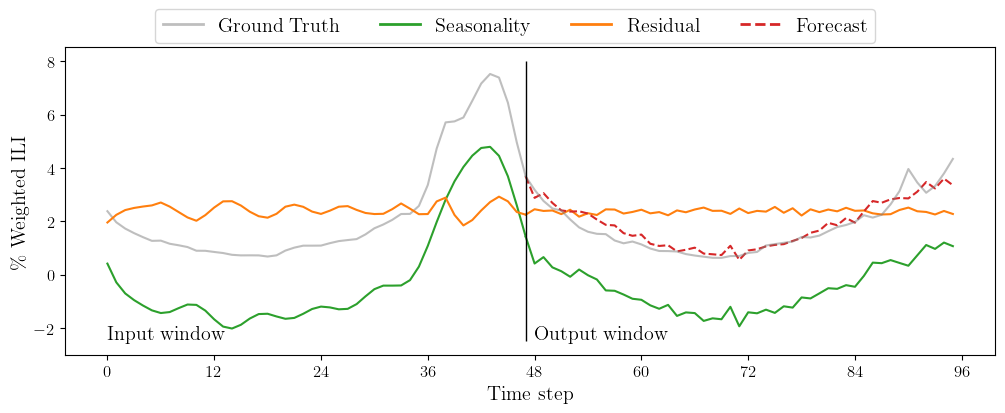

In [ ]:
SUM_COLOR = ("tab:grey",0.5)
FORECAST_COLOR = "tab:red"
SEASONAL_COLOR = "tab:green"
RESIDUAL_COLOR = "tab:orange"
n_components = model.out_interpretable.shape[0]

fig, ax = plt.subplots(figsize=(12,4))
# Plot input
x = data.get_attr_flat("X_test", order="NCL")[instance_index, channel_index]
seasonal = data.get_attr_flat("X_test_seasonal", order="NCL")[instance_index, channel_index]
residual = data.get_attr_flat("X_test_residual", order="NCL")[instance_index, channel_index]
comps = {
    "seasonal": seasonal,
    "residual": residual,
}
colors = {
    "seasonal": SEASONAL_COLOR,
    "residual": RESIDUAL_COLOR,
}
ax.plot(np.arange(len(x)),x,color=SUM_COLOR)
ax.plot(np.arange(len(seasonal)),seasonal,color=SEASONAL_COLOR)
ax.plot(np.arange(len(residual)),residual,color=RESIDUAL_COLOR)

# # Plot forecast
for component in range(n_components):
    concat = np.concatenate([comps[data.decomposition_variables[component]][-1:], model.out_interpretable[component,instance_index,channel_index]])
    ax.plot(np.arange(len(concat))+len(x)-1, concat, label=data.decomposition_variables[component], color=colors[data.decomposition_variables[component]])
yhat = np.concatenate([x[-1:], y_pred[instance_index,channel_index]])
ax.plot(np.arange(len(yhat))+len(x)-1, yhat, label="y", color=FORECAST_COLOR, linestyle="--")
ytrue = np.concatenate([x[-1:], data.get_attr_flat("y_test", order="NCL")[instance_index, channel_index]])
ax.plot(np.arange(len(ytrue))+len(x)-1, ytrue, label="y", color=SUM_COLOR)

legend_artists = {
    "Ground Truth": Line2D([0], [0], color=SUM_COLOR, lw=2),
    "Seasonality": Line2D([0], [0], color=SEASONAL_COLOR, lw=2),
    "Residual": Line2D([0], [0], color=RESIDUAL_COLOR, lw=2),
    "Forecast": Line2D([0], [0], color=FORECAST_COLOR, lw=2, linestyle="--"),
}

fig.legend(handles=list(legend_artists.values()), 
           labels=list(legend_artists.keys()), 
           ncol=len(legend_artists), 
           loc="upper center", 
           fontsize="x-large", 
           bbox_to_anchor=(0.5, 1))

ax.vlines(x=len(x)-1,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],color="black",lw=1)

ax.text(s="Input window", x=0, y=ax.get_ylim()[0] *0.8, fontdict={"fontsize": "x-large"})
ax.text(s="Output window", x=horizon, y=ax.get_ylim()[0] *0.8, fontdict={"fontsize": "x-large"})

ax.set_xlabel("Time step", fontdict={"fontsize": "x-large"})
ax.set_xticks(np.arange(9)*12, np.arange(9)*12, fontsize= "large")
ax.set_ylabel("\% Weighted ILI", fontdict={"fontsize": "x-large"})
ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize": "large"})

fig.savefig("plots/interpretability_fourier_topk_illness.pdf", bbox_inches="tight");

In [16]:
dataset = "transactions"
algorithm = "GenericNBeats"
decomp = c.interpretability_decomps[4]
channel_index = c.interpretability_channels[0]
instance_index = c.interpretability_samples[0]
model, data, y_pred = train_predict_model(decomp, algorithm, dataset, {}, wrap=False)
horizon = y_pred.shape[-1]

/Users/tikr7960/Library/Python/3.9/lib/python/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


/var/folders/y9/3vmyk1sj3gdg57c8wdhmps4m0000gp/T/ipykernel_54384/3041903837.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize": "large"})


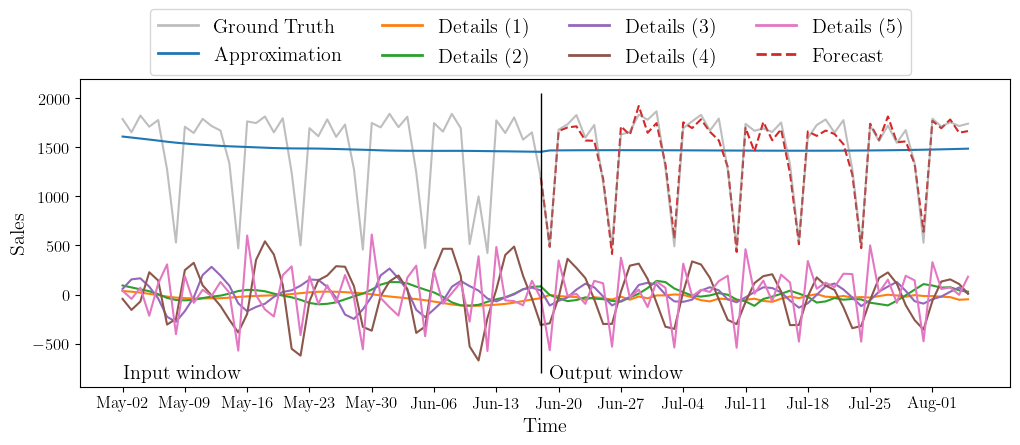

In [23]:
SUM_COLOR = ("tab:grey",0.5)
FORECAST_COLOR = "tab:red"

COMPONENT_COLORS = ["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:brown", "tab:pink"]
channel_index = 0
instance_index = 0
n_components = model.intermediate_outputs.shape[0]

fig, ax = plt.subplots(figsize=(12,4))
# Plot input
x = data.get_attr_flat("X_test", order="NCL")[instance_index, channel_index]
components = [data.get_attr_flat(f"X_test_{i}", order="NCL")[instance_index, channel_index] for i in data.decomposition_variables]

ax.plot(np.arange(len(x)),x,color=SUM_COLOR)
for comp, color in zip(components, COMPONENT_COLORS):
    ax.plot(timestamps[:len(comp)],comp,color=color)

# # Plot forecast
for comp, color, pred in zip(components, COMPONENT_COLORS, model.intermediate_outputs):
    concat = np.concatenate([comp[-1:], pred[instance_index,channel_index]])
    ax.plot(timestamps[len(x)-1:len(x)-1+len(concat)], concat, color=color)
yhat = np.concatenate([x[-1:], y_pred[instance_index,channel_index]])
ax.plot(timestamps[len(x)-1:len(x)-1+len(yhat)], yhat, label="y", color=FORECAST_COLOR, linestyle="--")
ytrue = np.concatenate([x[-1:], data.get_attr_flat("y_test", order="NCL")[instance_index, channel_index]])
ax.plot(timestamps[len(x)-1:len(x)-1+len(ytrue)], ytrue, label="y", color=SUM_COLOR)

legend_artists = {
    "Ground Truth": Line2D([0], [0], color=SUM_COLOR, lw=2),
}
for color, name in zip(COMPONENT_COLORS, data.decomposition_variables):
    if name == "approximation":
        n = "Approximation"
    else:
        n = f"Details ({int(name)+1})"
    legend_artists[f"{n}"] = Line2D([0], [0], color=color, lw=2)
legend_artists["Forecast"] = Line2D([0], [0], color=FORECAST_COLOR, lw=2, linestyle="--")

fig.legend(handles=list(legend_artists.values()), 
           labels=list(legend_artists.keys()), 
           ncol=4,
           loc="upper center", 
           fontsize="x-large", 
           bbox_to_anchor=(0.5, 1.08))

ax.vlines(x=len(x)-1,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],color="black",lw=1)

ax.text(s="Input window", x=0, y=ax.get_ylim()[0] *0.9, fontdict={"fontsize": "x-large"})
ax.text(s="Output window", x=horizon, y=ax.get_ylim()[0] *0.9, fontdict={"fontsize": "x-large"})

ax.set_xlabel("Time", fontdict={"fontsize": "x-large"})
ax.xaxis.set_major_locator(plt.MultipleLocator(7))

# Customize the font size of x-axis ticks
plt.setp(ax.xaxis.get_majorticklabels(), fontsize='large')
ax.set_xticks(ax.get_xticks()[1:-2])

ax.set_ylabel("Sales", fontdict={"fontsize": "x-large"})
ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize": "large"})

fig.savefig("plots/interpretability_gbeats_transactions.pdf", bbox_inches="tight");